# 3. Data wrangling

My code's initial section is devoted to data wrangling, which is the process of getting the data ready for analysis by cleaning and organizing it.

I start by importing the necessary libraries. pandas is used for data manipulation and analysis. isodate is helpful for parsing ISO 8601 duration strings into Python objects. matplotlib.pyplot and seaborn are for data visualization.

Since there are two csv files created while scraping data, I merge them together into one data frame and use it for all the analysis. The 'publishedAt' column in the dataset contains the dates when the videos were published. Initially, these dates are in string format. I use pd.to_datetime to convert this column into a datetime format, which is much more versatile for analysis. I extract the year from the 'publishedAt' datetime objects and create a new column. This will be useful for analyses that require data aggregated on a yearly basis. The view counts in the dataset are very large numbers, which can be cumbersome to work with. To simplify, I scale these numbers down by dividing them by one million (1e6). 

The video duration in the dataset is in ISO 8601 duration format, which is not straightforward to analyze. I define a function duration_to_minutes that converts these duration strings into a number of minutes. The 'tags' column contains tags associated with each video, but they are combined in a single string. I use the split method to separate these tags into a list of individual tags for each video. This will allow for more detailed analysis of tags later on.


In [1]:
# Loading required libraries
import pandas as pd
import isodate
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets from the two CSV files
df_mrbeast = pd.read_csv('mrbeast.csv')
df_pewdiepie = pd.read_csv('pewdiepie.csv')

# Add a new column 'channel' to each DataFrame
df_mrbeast['Channel'] = 'MrBeast'
df_pewdiepie['Channel'] = 'PewDiePie'

# Merge the two DataFrames into one
df = pd.concat([df_mrbeast, df_pewdiepie], ignore_index=True)

# Convert the 'publishedAt' column to datetime format
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Extract year from 'publishedAt' and create a new column for it
df['Year'] = df['publishedAt'].dt.year

# Convert view counts to millions for easier analysis
df['viewCount'] = df['viewCount'] / 1e6

# Function to convert duration to minutes
def duration_to_minutes(duration_str):
    try:
        return isodate.parse_duration(duration_str).total_seconds() / 60
    except:
        return 0

# Converting duration to minutes and creating a new column for it
df['duration_minutes'] = df['duration'].apply(duration_to_minutes)

# Splitting the tags into a list
df['tags'] = df['tags'].apply(lambda x: x.split(','))


# 4. Data Visualization

Lets begin answering the research questions. For reference, they are

-  What are the yearly trends in video view counts?
- What is the general correlation between the like count and view count across the dataset of YouTube videos, and what does the scatter plot reveal about their relationship?
- What are the top 10 tags observed in all the youtube videos
- How does the plot for Average like v/s Video duration look like
- What is the average duration of videos for PewDiePie and MrBeast, and how does video length relate to popularity metrics like views and likes?




## RQ1 - What are the yearly trends in video view counts?

In the graph presented for RQ1, we're looking at the average yearly trends in video view counts, measured in millions. This bar chart shows a clear upward trajectory in the average number of views that videos receive over the years. Starting from 2006, there's a noticeable increase, especially from around 2017 onwards, with a significant peak in 2022. This could suggest that content is becoming more engaging or that more viewers are flocking to YouTube each year.

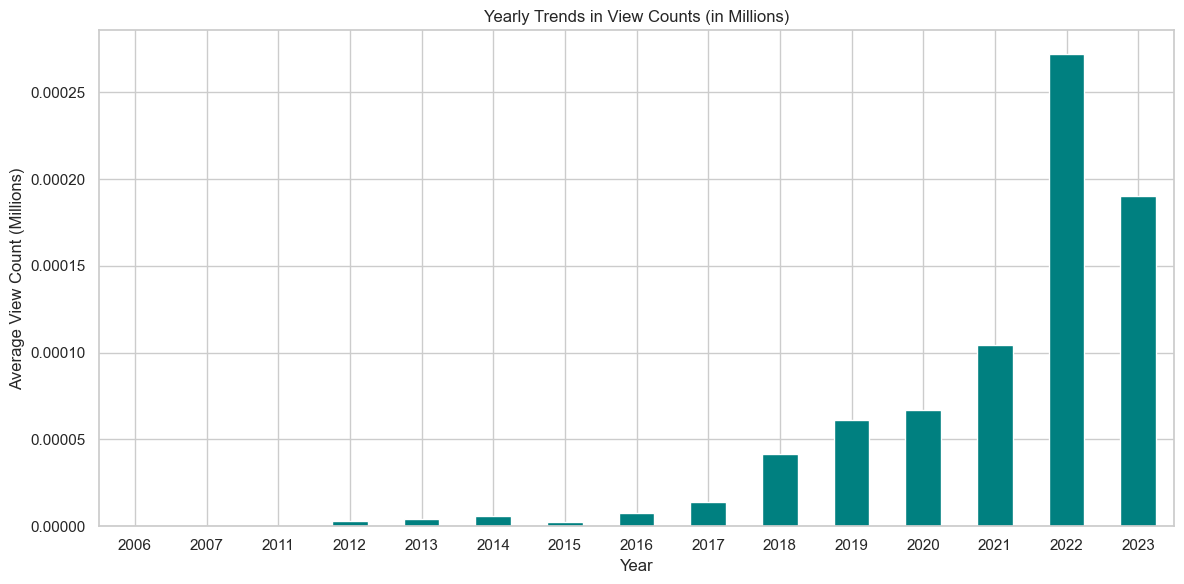

In [3]:
# Changing the style of the plot to a Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")
# Converting view counts to millions
yearly_views = df.groupby('Year')['viewCount'].mean() / 1e6 

# Plotting the trend of views per year with improved aesthetics
plt.figure(figsize=(12, 6))
yearly_views.plot(kind='bar', color='teal')
plt.title('Yearly Trends in View Counts (in Millions)')
plt.xlabel('Year')
plt.ylabel('Average View Count (Millions)')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for better readability
plt.tight_layout()  # Adjusting the plot 
plt.show()


To verify the absence of bars, I have subseted the data from 2006 and 2012 and plotted the below graph. Interesting thing to note is that PewDiePie started his channel in 2006 and Mr Beast in 2012. And since youtube itself began operating in 2005 ,i.e., a lesser number of users in 2006 is obvious, and hence no views were actually reported in the data. There could be enough users active by 2012. Hence, we are seeing an active increase from this year on. 


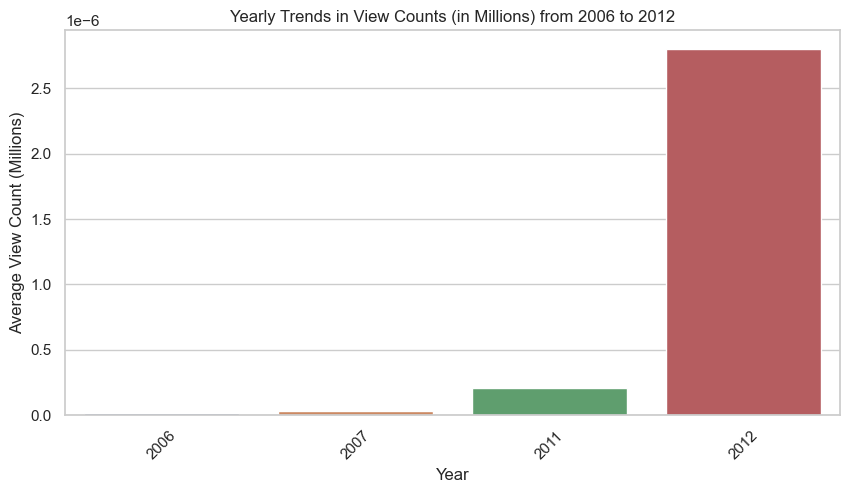

In [4]:
filtered_df = df[(df['Year'] >= 2006) & (df['Year'] <= 2012)].copy()

# Convert view counts to millions for the filtered data
filtered_df['viewCount'] = filtered_df['viewCount'] / 1e6

# Change the style of the plot to a Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting the trend of views per year with improved aesthetics for the specified years
plt.figure(figsize=(10, 5))
sns.barplot(x='Year', y='viewCount', data=filtered_df, errorbar=None)  # Using a Seaborn palette for color
plt.title('Yearly Trends in View Counts (in Millions) from 2006 to 2012')
plt.xlabel('Year')
plt.ylabel('Average View Count (Millions)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

## RQ2: What is the general correlation between the like count and view count across the dataset of YouTube videos, and what does the scatter plot reveal about their relationship?

In this scatter plot for RQ2, we're analyzing the relationship between like count and view count of YouTube videos. The horizontal axis represents the like count while the vertical axis shows the view count, both illustrating a strong positive correlation of 0.91, which is quite high. This suggests that videos with more likes tend to also have more views. 

   The scatter plot visually reinforces this correlation, as we can observe a dense clustering of data points along a line sloping upwards. This means that as likes increase, views tend to increase as well. However, there are a few outliers with a high number of views but not as many likes, which could indicate videos that are watched frequently but don't necessarily prompt a high engagement in terms of likes.

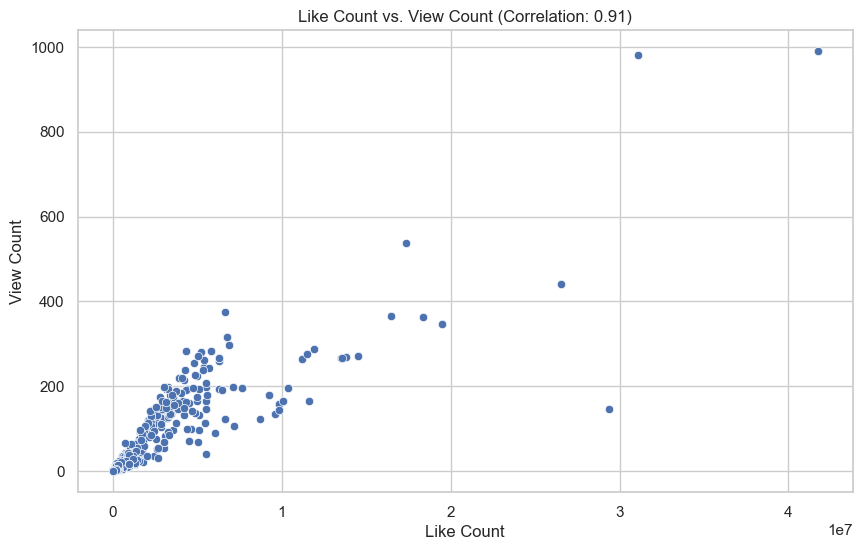

,likeCount,viewCount
likeCount,1.000000,0.905779
viewCount,0.905779,1.000000


In [5]:
# Calculate the correlation matrix
correlation_matrix = df[['likeCount', 'viewCount']].corr()

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='likeCount', y='viewCount')

# Adding the correlation coefficient to the plot
plt.title(f'Like Count vs. View Count (Correlation: {correlation_matrix.loc["likeCount", "viewCount"]:.2f})')
plt.xlabel('Like Count')
plt.ylabel('View Count')
plt.grid(True)
plt.show()

# Output the correlation coefficient
correlation_matrix

## RQ3 What are the top 10 tags observed in all the youtube videos

In this bar chart, we're looking at the top 10 tags based on the average view count of YouTube videos, which is quite an interesting aspect of our analysis. The 'unboxing' tag leads the chart, which isn't surprising given how popular unboxing videos have become, offering first impressions and product features. Following close behind are 'amazon mystery box' and 'iphone', showing a strong viewer interest in tech and mystery products. The 'slime' and 'experiments' tags likely point to the entertainment and educational content that attracts a lot of views, especially from younger audiences. 

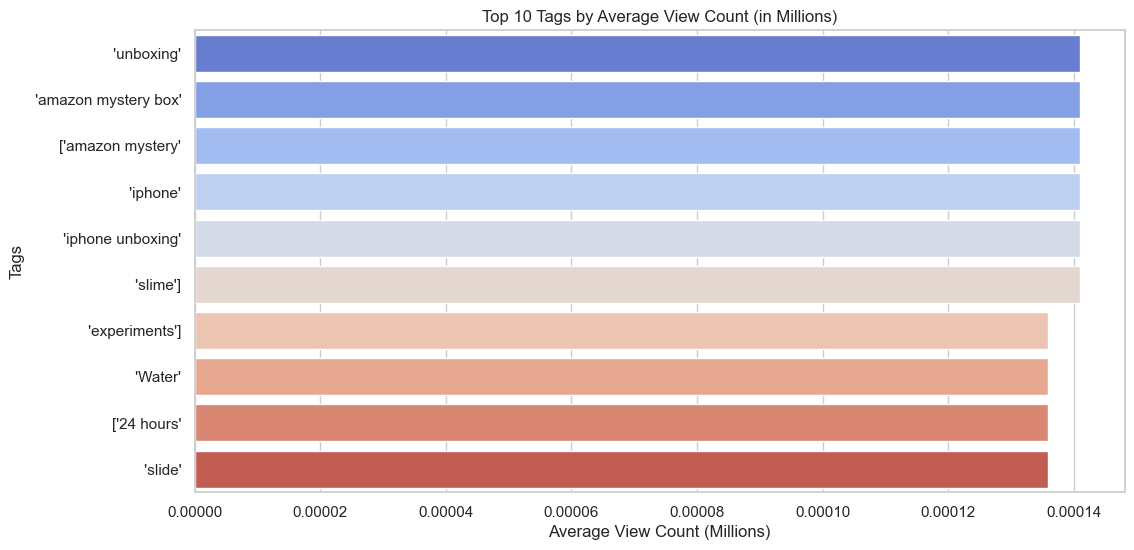

In [6]:
# Explode the DataFrame such that each tag gets its own row, maintaining the association with the video's view count
df_exploded = df.explode('tags')

# Now group by the tags and calculate the average view count for each tag
tag_view_counts = df_exploded.groupby('tags')['viewCount'].mean().sort_values(ascending=False) / 1e6  # Convert to millions

# Skip the first tag which is likely to be '[]' or empty and then take the next top 9 tags for plotting
top_tags = tag_view_counts.iloc[1:11]  # Adjusted to skip the first entry

plt.figure(figsize=(12, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette="coolwarm")
plt.title('Top 10 Tags by Average View Count (in Millions)')
plt.xlabel('Average View Count (Millions)')
plt.ylabel('Tags')
plt.show()

## 4. How does the plot for Average like v/s Video duration look like

The x-axis shows the video duration in minutes, and the y-axis represents the average number of likes. It is immediately noticeable that there is a significant spike for shorter videos, indicating that videos of shorter duration tend to receive a high number of likes. After this initial spike, the average likes level off as the video duration increases. There are some exceptions, as seen by the occasional spikes, which suggest that there are longer videos that also manage to garner a substantial number of likes. However, the general pattern indicates that shorter videos are more likely to receive a higher average number of likes, which could be due to viewers' preferences for concise and engaging content

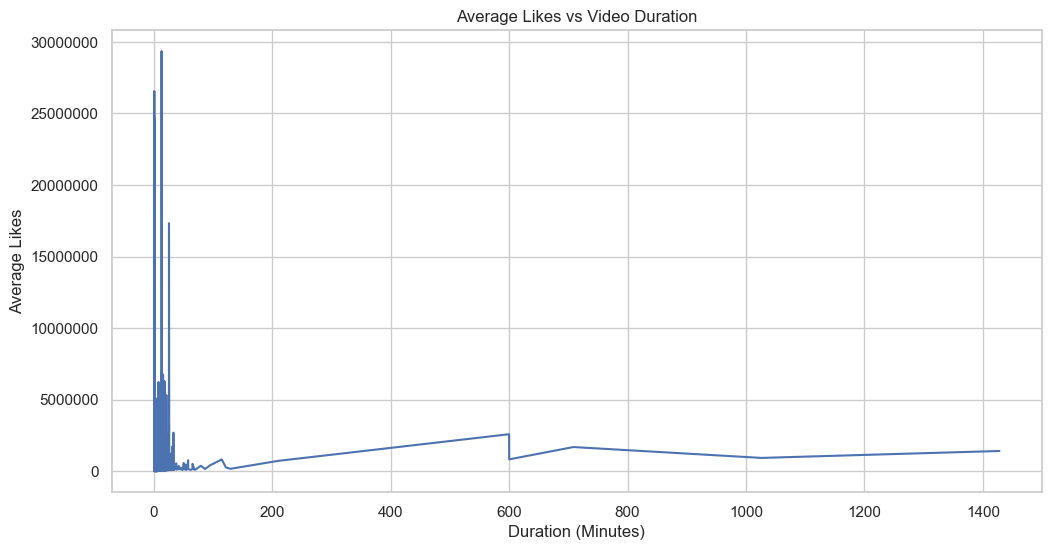

In [7]:
# Calculating average likes per video duration
avg_likes_per_duration = df.groupby('duration_minutes')['likeCount'].mean().reset_index()

# Plotting the graph with more readable x-axis format
plt.figure(figsize=(12, 6))
sns.lineplot(x='duration_minutes', y='likeCount', data=avg_likes_per_duration)
plt.title('Average Likes vs Video Duration')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Average Likes')

# Adjusting x-axis to display likes in a more readable format (without exponent notation)
plt.ticklabel_format(style='plain', axis='y')

plt.show()


## RQ5: What is the average duration of videos for PewDiePie and MrBeast, and how does video length relate to popularity metrics like views and likes?

The first plot, "Video Duration vs View Count," shows that most videos, regardless of channel, tend to cluster within a certain range of durations, and there's a wide distribution in view counts. There's a noticeable concentration of videos with higher views within shorter durations, especially for MrBeast, suggesting his shorter videos tend to be quite popular. However, both channels have outliers with longer videos also achieving a significant number of views.

The second plot, "Video Duration vs Like Count," similarly depicts a concentration of videos with higher likes within shorter durations. MrBeast's videos show a particularly strong correlation between shorter video lengths and higher likes. PewDiePie's videos demonstrate a more varied pattern, suggesting that his viewers might engage differently with content based on length.

This could imply that there's no one-size-fits-all approach to video length and that understanding audience preference is key.

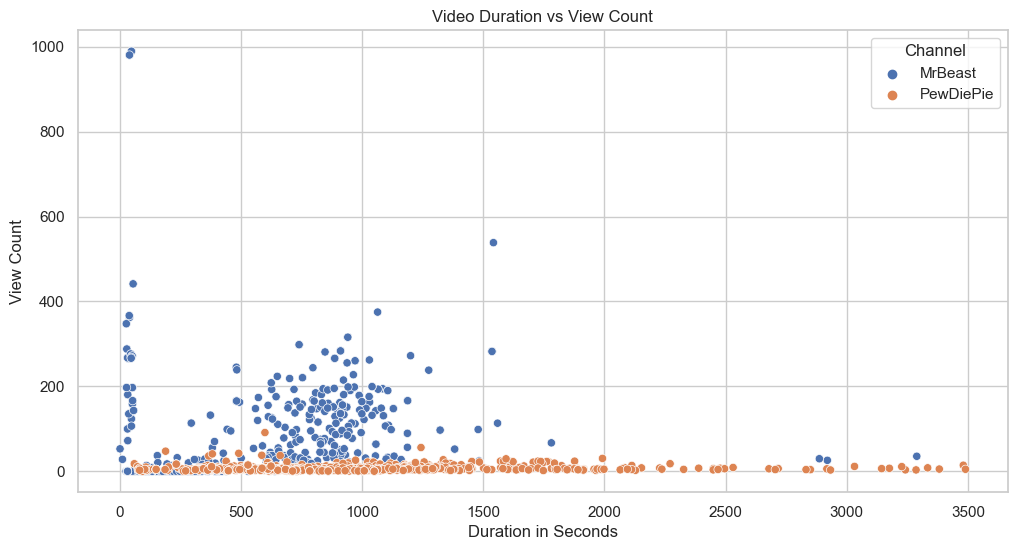

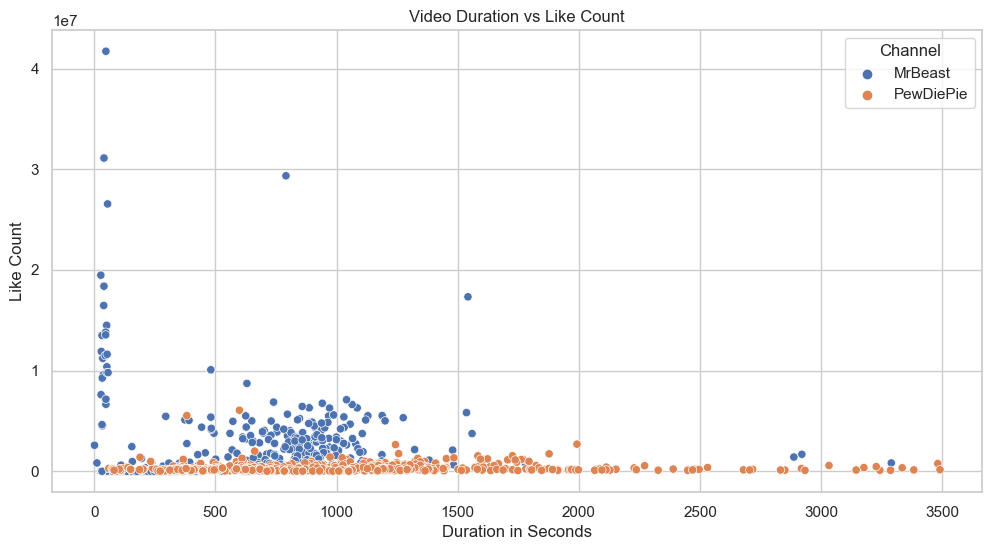

Channel
MrBeast      518.845638
PewDiePie    980.574103
Name: DurationSeconds, dtype: float64

In [8]:
import re

def convert_duration_to_seconds(duration_str):
    """
    Convert a duration string in the format 'PT#M#S' (ISO 8601 duration) to seconds.
    Example: 'PT1M30S' -> 90 seconds
    """
    if duration_str.startswith('PT'):
        minutes = re.search(r'(\d+)M', duration_str)
        seconds = re.search(r'(\d+)S', duration_str)
        minutes = int(minutes.group(1)) if minutes else 0
        seconds = int(seconds.group(1)) if seconds else 0
        return minutes * 60 + seconds
    else:
        return 0  # Or handle other formats, if applicable
    
df['DurationSeconds'] = df['duration'].apply(lambda x: convert_duration_to_seconds(x))

# Calculate the average duration for each YouTuber
average_duration = df.groupby('Channel')['DurationSeconds'].mean()

# Scatter plots to show the relationship between Duration and Popularity Metrics (Views and Likes)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='DurationSeconds', y='viewCount', hue='Channel')
plt.title('Video Duration vs View Count')
plt.xlabel('Duration in Seconds')
plt.ylabel('View Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='DurationSeconds', y='likeCount', hue='Channel')
plt.title('Video Duration vs Like Count')
plt.xlabel('Duration in Seconds')
plt.ylabel('Like Count')
plt.show()

# Output average duration
average_duration

# 5. Data Analysis

I used the Random Forest model to guess how many views a YouTube video would get based on three things: how long the video is, how many likes it has, and how many comments it gets. After teaching the model with some of the data (training set), I checked how good it was using another part of the data (test set). The model's performance was measured using Mean Squared Error (MSE), which was 206.62. This number tells us how close the model's guesses are to the actual number of views. In our case, this seems okay, considering how big view numbers can be.

In [9]:
# Loading libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def convert_minutes_to_seconds(duration_str):
    try:
        return int(duration_str) * 60  # Convert minutes to seconds
    except ValueError:
        return 0  # In case of any formatting issue

# Convert 'duration' to seconds
df['DurationSeconds'] = df['duration'].apply(convert_minutes_to_seconds)

# Feature matrix X and target variable y
X = df[['DurationSeconds', 'likeCount', 'commentCount']]
y = df['viewCount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 206.6216516467673


# 6. Conclusion

From all the research questions and the model results, here's what we found out:

- Videos from PewDiePie and MrBeast, especially shorter ones, tend to get a lot of likes.
- Certain topics or 'tags' like 'unboxing' and 'iPhone' are really popular.
- Our Random Forest model, which guessed the number of views, also showed us that likes and comments are good indicators of how popular a video might be.


## Future Improvements

- Youtube Analytics API Could give access to demographic details about the youtube subscribers, which would increase the scope of observations. Only the channel owner could view this information, or the owner must give access to the person doing analysis

- This can be extended over a specific category of videos(Science and informative videos) to see specific user behaviour.

- Youtube api also provides access to comments which can be used for sentiment analysis. Since the dislike count is 0, Maybe we can get deeper insights about people disliking the video.